<a href="https://www.kaggle.com/code/handandegerli/feature-engineering?scriptVersionId=185074319" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install missingno

In [2]:
#############################################
# FEATURE ENGINEERING & DATA PRE-PROCESSING
#############################################

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor #LOF:cok degişkenli aykırı değer yakalama yontemi
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler#standartlastırma, donusturme methodları

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

#this dataset is homecreditdefaultriskproject's train dataset from kaggle
def load_application_train():
    data = pd.read_csv("/kaggle/input/dataset-for-feature-engine/application_train.csv")
    return data

df = load_application_train()
df.head()


def load():
    data = pd.read_csv("/kaggle/input/dataset-for-feature-engine/titanic.csv")
    return data


df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


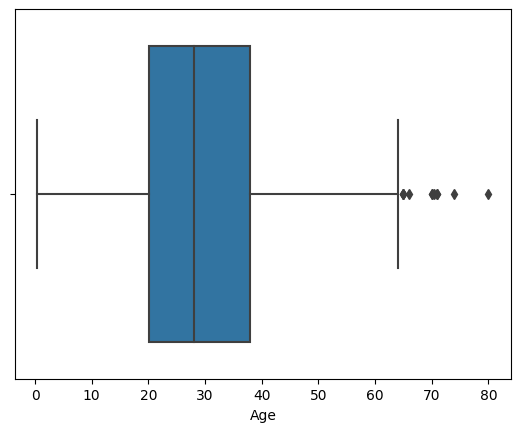

In [3]:
#############################################
# 1. Outliers (Aykırı Değerler)
#############################################

#############################################
# Aykırı Değerleri Yakalama
#############################################

###################
# Grafik Teknikle Aykırı Değerler
###################

sns.boxplot(x=df["Age"])
plt.show()

In [4]:
###################
# Aykırı Değerler Nasıl Yakalanır?
###################

q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

df[(df["Age"] < low) | (df["Age"] > up)].sort_values("Age", ascending= False)
df[(df["Age"] < low) | (df["Age"] > up)].index


Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [5]:
###################
# Aykırı Değer Var mı Yok mu?
###################

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)
df[~((df["Age"] < low) | (df["Age"] > up))].any(axis=None)
df[(df["Age"] < low)].any(axis=None)

# 1. Eşik değer belirledik.
# 2. Aykırılara eriştik.
# 3. Hızlıca aykırı değer var mı yok diye sorduk.


False

In [6]:
###################
# İşlemleri Fonksiyonlaştırmak
###################

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, "Age")
outlier_thresholds(df, "Fare")

(-26.724, 65.6344)

In [7]:
low, up = outlier_thresholds(df, "Fare")

In [8]:
df[(df["Fare"] < low) | (df["Fare"] > up)].head()
df[(df["Fare"] < low) | (df["Fare"] > up)].index

Index([  1,  27,  31,  34,  52,  61,  62,  72,  88, 102,
       ...
       792, 802, 820, 829, 835, 846, 849, 856, 863, 879], dtype='int64', length=116)

In [9]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, "Age")
check_outlier(df, "Fare")

True

In [10]:
###################
# grab_col_names
###################

dff = load_application_train()
dff.head()
dff.shape


(307511, 122)

In [11]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """
    
    #cardinalitesi yüksek değişken:  categorik.nunique>20

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [12]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
df.shape

num_cols = [col for col in num_cols if col not in "PassengerId"]

for col in num_cols:
    print(col, check_outlier(df, col))


Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True


In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


In [14]:
num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]

for col in num_cols:
    print(col, check_outlier(dff, col))


CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

In [15]:
###################
# Aykırı Değerlerin Kendilerine Erişmek
###################

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


In [16]:

grab_outliers(df, "Age")

grab_outliers(df, "Age", True)

age_index = grab_outliers(df, "Age", True)


outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q
     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 2457

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [17]:
#############################################
# Aykırı Değer Problemini Çözme
#############################################

###################
# Silme
###################

low, up = outlier_thresholds(df, "Fare")
df.shape

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

(775, 12)

In [18]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [19]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [20]:
num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    new_df = remove_outlier(df, col)

df.shape[0] - new_df.shape[0]

116

In [21]:
###################
# Baskılama Yöntemi (re-assignment with thresholds)
###################

low, up = outlier_thresholds(df, "Fare")

df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]

df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

df.loc[(df["Fare"] > up), "Fare"] = up

df.loc[(df["Fare"] < low), "Fare"] = low

In [22]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:
df = load()
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))


Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True
Age False
Fare False


In [24]:
###################
# Recap
###################

df = load()
outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", index=True)

remove_outlier(df, "Age").shape
replace_with_thresholds(df, "Age")
check_outlier(df, "Age")

#mostUsed: 1-outlier_thresholds 2-replace_with_thresholds 3-grab_col_names

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


False

In [25]:
#############################################
# Çok Değişkenli Aykırı Değer Analizi: Local Outlier Factor
#############################################

# age 17, marriage 3: tek değişkenli iken anlamlı olmayıp yanyana geldiğinde outlier olabilir.

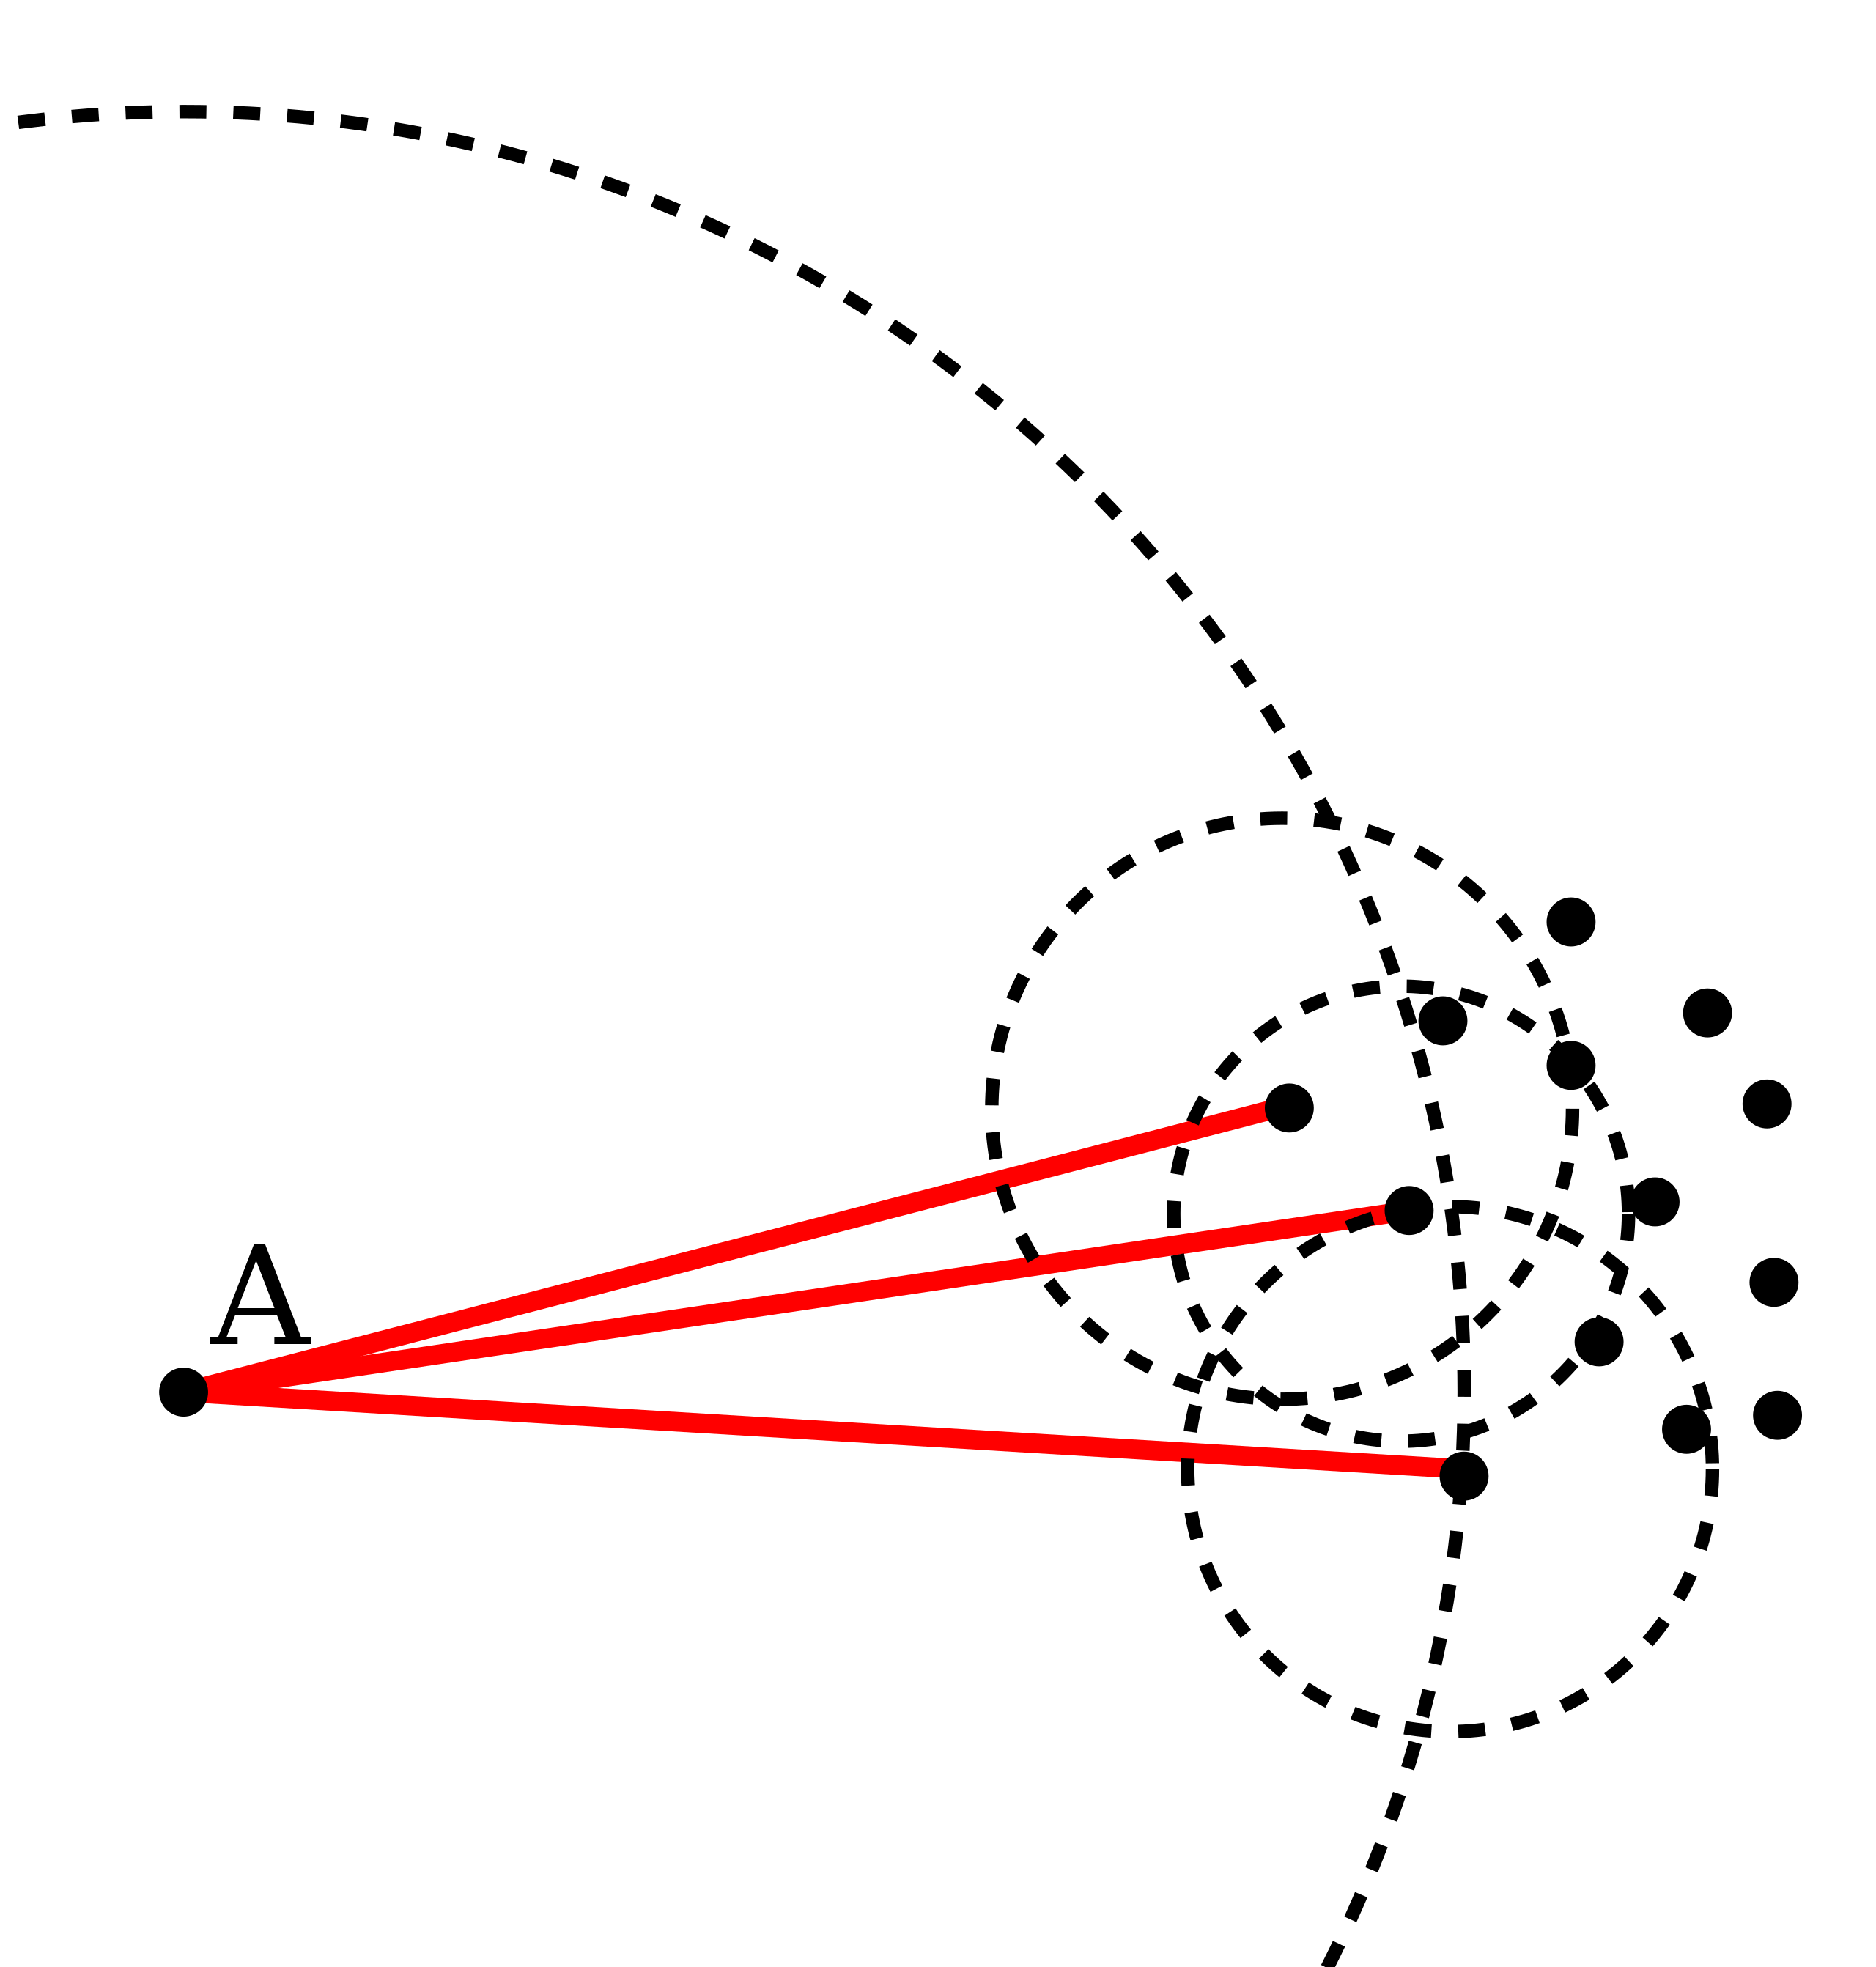

Eğer bir nokta komşularının yoğunluğundan anlamlı bir şekilde düşük ise bu durumda bu nokta daha seyrek bir bölgededir. Yani demek ki bu aykırı değer olabilir yorumu yapılır. Örnek olarak A noktası verilebilir. LOF yöntemi bize bu komşulara göre uzaklık skoru hesaplama imkanı sağlar. 


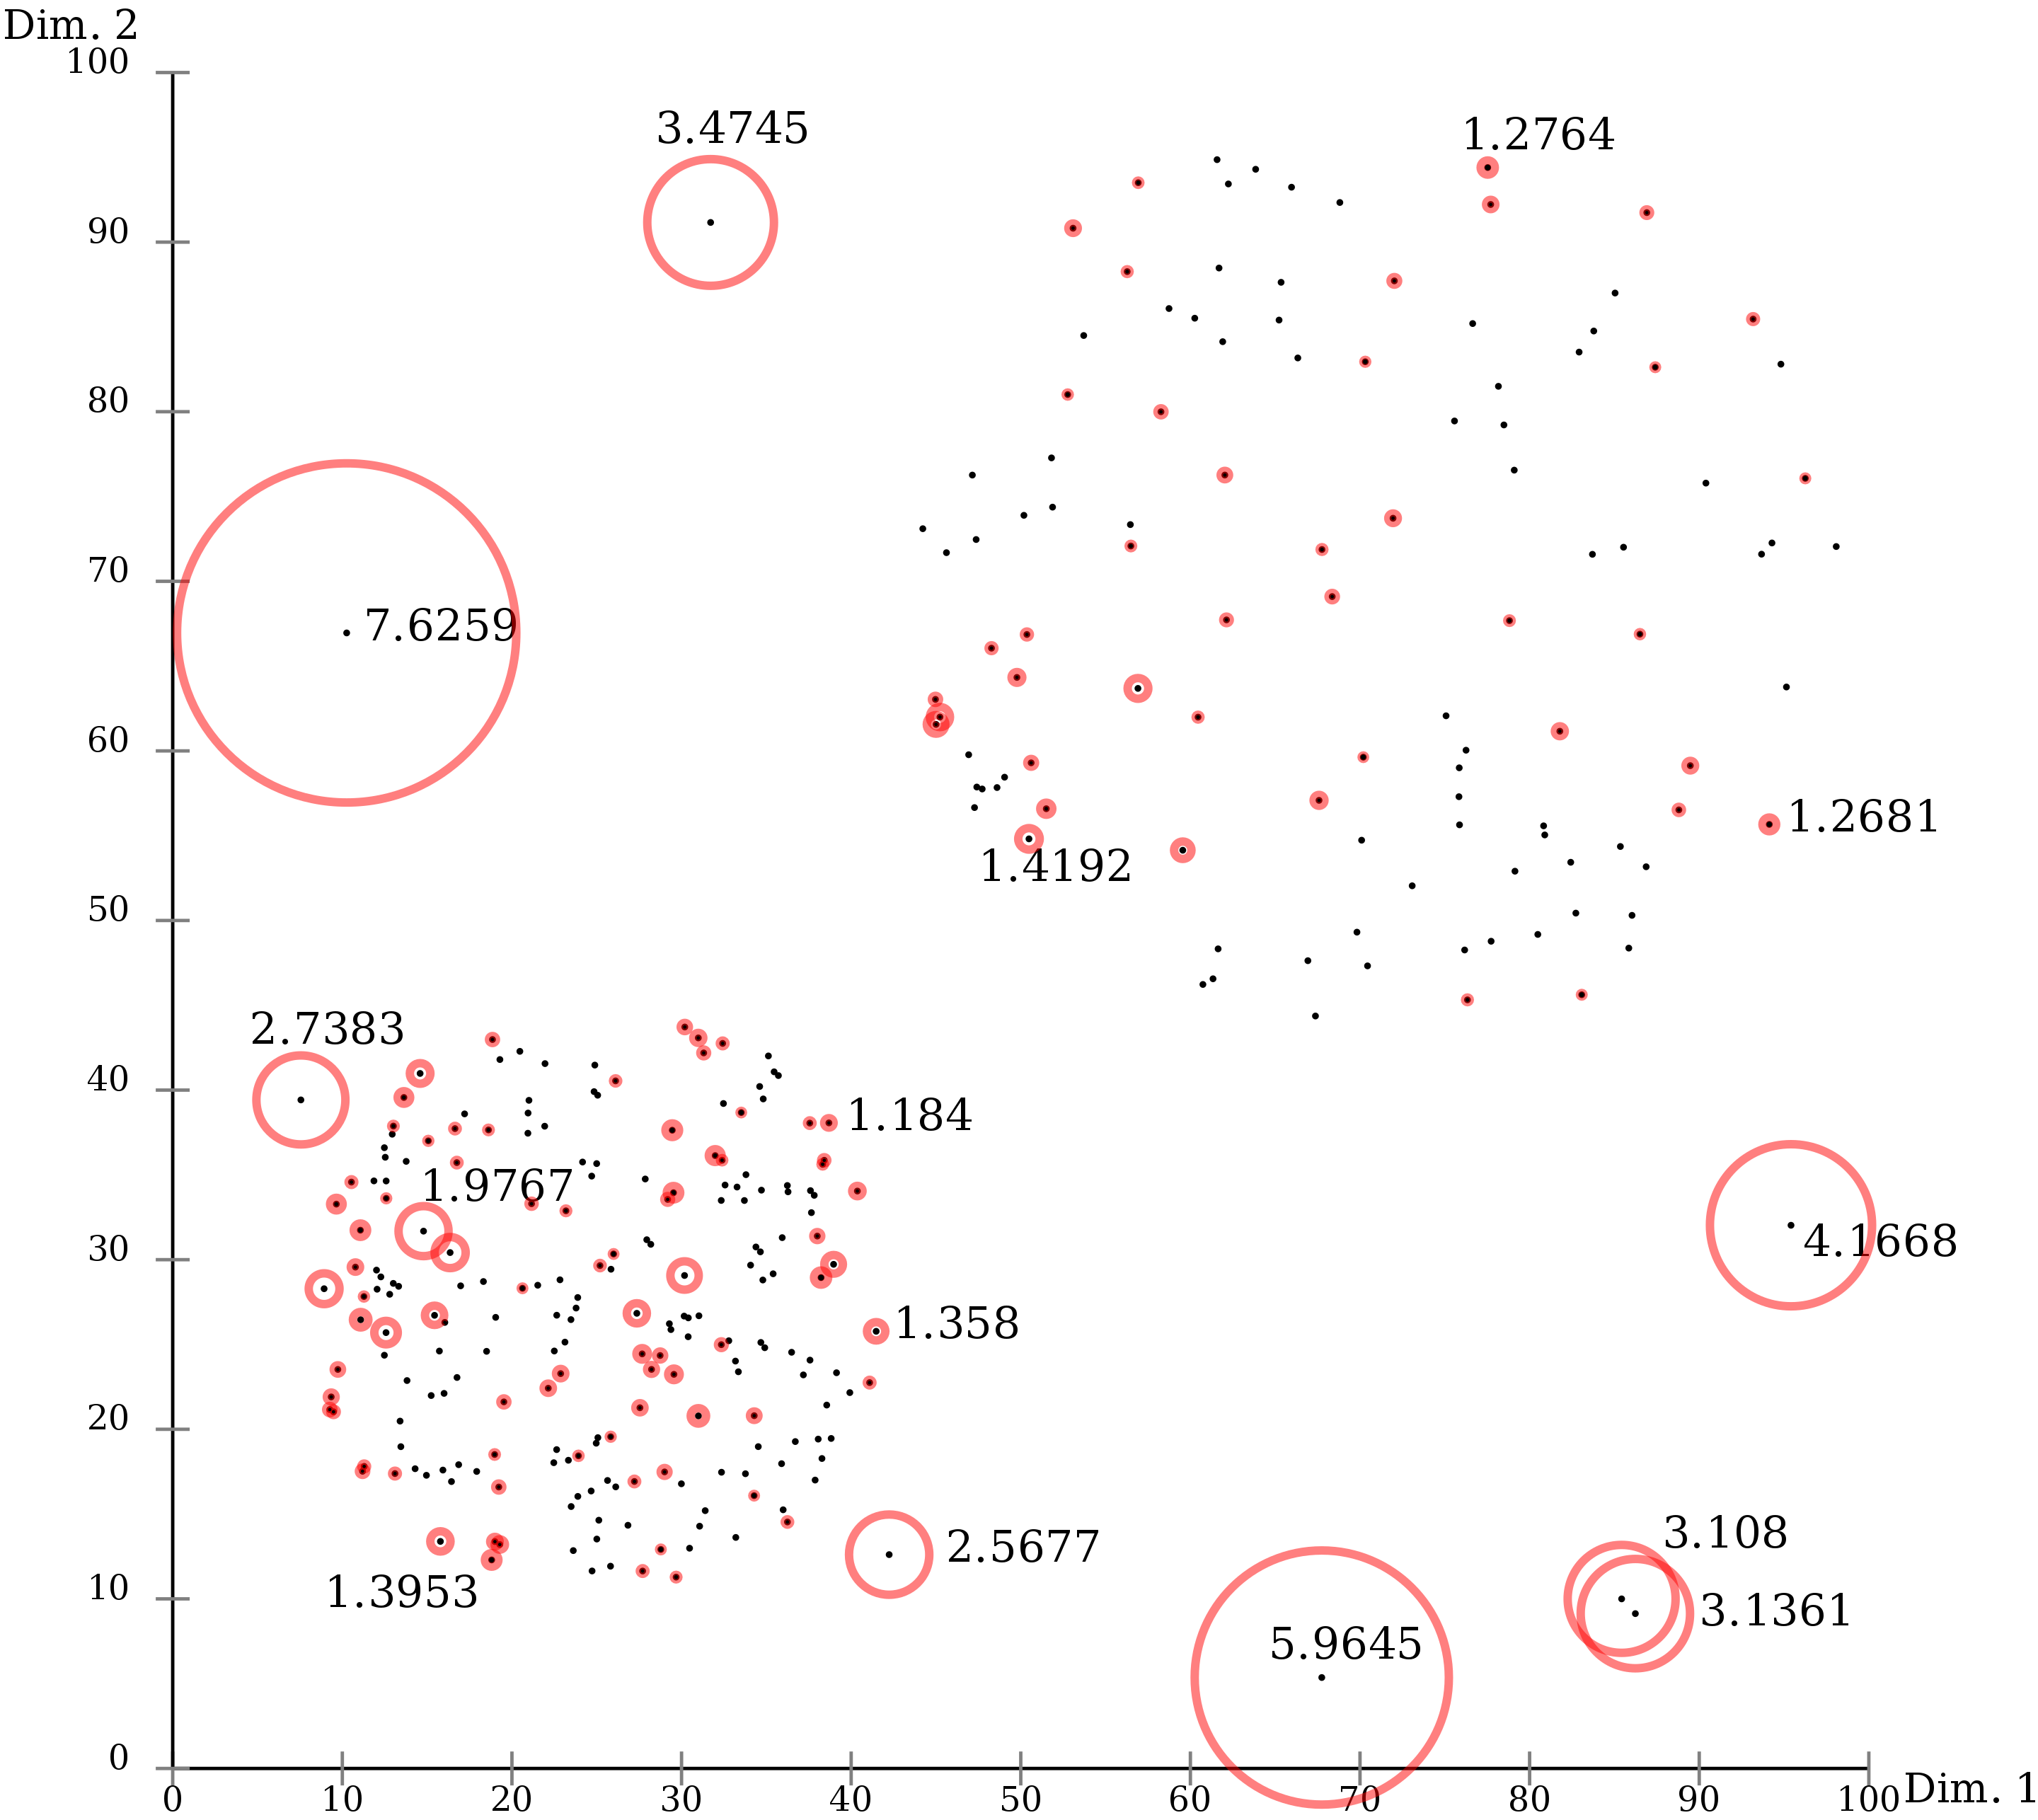

LOF yöntemi der ki “ben size bir skor vereceğim. Bu, benden aldığınız skor 1’e ne kadar yakın olursa o kadar iyidir, 1’den uzaklaştıkça ilgili gözlemin outlier olma ihtimali artar” der. Burada küçük noktalar görülen kırmızılar inlier lardır.

In [26]:
df = sns.load_dataset('diamonds')
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
df.head()
df.shape

(53940, 7)

In [27]:
for col in df.columns:
    print(col, check_outlier(df, col))


low, up = outlier_thresholds(df, "carat")

df[((df["carat"] < low) | (df["carat"] > up))].shape

low, up = outlier_thresholds(df, "depth")

df[((df["depth"] < low) | (df["depth"] > up))].shape


carat True
depth True
table True
price True
x True
y True
z True


(2545, 7)

Dikkat!.
outlier_thresholds 25’e 75’likti literatürde,ama ben bunu 5’e 95 kullanırım. “İyi de neden?” Şimdi LOF yöntemine gittiğimizde aykırı değer sayısına odaklanın.
Tek tek değişkenlere odaklanın. Eğer konuya tek değişkenli yaklaşıp 25’e 75’lik silsediyle veya doldursaydık; silsedik ciddi bir veri kaybı olacaktı, doldursak da tortu yaratacaktı.
Kendi kendimize veri setine gürültü ekleyecektik yani, problem oluşturacaktık.
Ağaç yöntemleri kullanıyorsak dokunmamayı tercih etmeliyiz. benim yaklaşımım çok ucundan bi traşlıyım, ekstra aykırı olanları traslıyalım, veri kaybını minimize edecek sekilde. Ciddi bir problem gözden kaçmamalı.Ciddi bir problem ispat etmeye çalışalım.
Burada tek degişkenli yaklasınca cok yuksek sayıda aykırılıklar geldi. Bir de buna cok degişkenli yaklasırsak nasıl olacak inceleyelim... 

In [28]:
clf = LocalOutlierFactor(n_neighbors=20)#5 olur 3 olur ya da brute force diyebileceğimiz sekilde dongu ile degistırebiliriz. 
clf.fit_predict(df)

df_scores = clf.negative_outlier_factor_
df_scores[0:5]
# df_scores = -df_scores #elbow yontemi için negative ele almak daha iyi
np.sort(df_scores)[0:5]

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

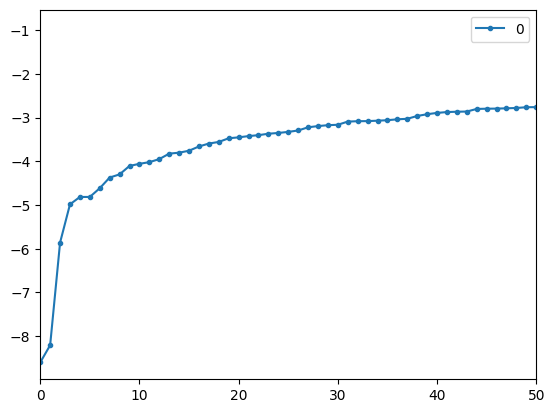

In [29]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')#-50 outlier scoru
plt.show()

In [30]:
th = np.sort(df_scores)[3]

In [31]:
df[df_scores < th]

df[df_scores < th].shape

(3, 7)

In [32]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,3.530,4.040,4.520,5.150,31.800


41918: depth 78.200 ama max 79 bu işte bir terslik var çünkü max daha fazla ama neden onu yakaladı aykırı diye çünkü çoklu değişken yaklasımında aykırılık var. belki o depth de o price olmaz.\ 
48410: z 31.800 ama max ile aynı ortalamadan çok farklı.\
49189: y 31.800 ama y ortalama 5.735
sonuç: çok değişkenli aykırılklar yakalandı.

In [33]:
df[df_scores < th].index

df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)


,carat,depth,table,price,x,y,z


53940: gozlem sayısı
tek degişkenli yaklasımda 2545 outliers
çok değişkenli yaklasımda 3 outliers
sildik.

Neden baskılamak yerine sildik?\
Çünkü burada onemli olan nokta su burada 3 gozlem vardı yapılabilir. Ama yuzlerce aykırılıkları oldugunda burada yuzlerce aynı degeri veri setine baskılamıs olucaz. Kendi elimizle zorla duplike kayıt olusturcaz. Zorla bozucaz veriyi. tortu, gürültü olcak. 

Eger gozlem sayısı fazlaysa degistirme gb sekilde dokunmak ciddi problemlere sebep olur.

Eger agac yontemi ile çalısıyorsak hiç dokunmayalım.

Benim yaklasımım cok ucundan tıraslıyıp outliers trashholds ve replacewithtrashholds ile gozlemlere kendi içinde yaklascaz. tek degiskenli ve cok degiskenliyi gozardı etmeyiz. cunku litaraturden farklı olarak interquartile range i 5-95 1-99 gb ucundan dokunalım dersek trashold gelcek. Kırpılacak olan gozlem sayısı cok daha aza duseceginden dolayı bir çok aykırı değerin yerine duplike kayıt uretmekten daha faydalı olacaktır.

Gözlem sayısı çoksa baskılama yontemi dogru degildir.

az olursa cok degişkenli baktıktan sonra datasetten o degişkenler çıkarılmalıdır.

Azlık-cokluk ise mesela: 500 satır 2 tane ise bu ii sil, 500 tanede 50 tane ise cok yuksektir. 500.000 tane satır varsa 1.000 tane aykırı deger varsa sil gitsin. şeklinde orneklendirebilriz. Datasetine ve yoruma baglıdır. 

Ama yine de agac yonteminde dokuncaksak çok ucundan dokunalım! ama dogrusal yontemlerde aykırı deger problemi hala onemli doldurmak yerine aykırı deger az sayıda ise sil, doldurmak yerine tek degiskenli yaklasıp baskılamak gereklidir yine doldurmak yerine.


In [34]:
#############################################
# Missing Values (Eksik Değerler)
#############################################

#############################################
# Eksik Değerlerin Yakalanması
#############################################

df = load()
df.head()

# eksik gozlem var mı yok mu sorgusu
df.isnull().values.any()

# degiskenlerdeki eksik deger sayisi
df.isnull().sum()

# degiskenlerdeki tam deger sayisi
df.notnull().sum()

# veri setindeki toplam eksik deger sayisi
df.isnull().sum().sum()

# en az bir tane eksik degere sahip olan gözlem birimleri
df[df.isnull().any(axis=1)]

# tam olan gözlem birimleri
df[df.notnull().all(axis=1)]

# Azalan şekilde sıralamak
df.isnull().sum().sort_values(ascending=False)

(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

In [35]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

missing_values_table(df, True)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220
          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


['Age', 'Cabin', 'Embarked']

In [36]:
#############################################
# Eksik Değer Problemini Çözme
#############################################

missing_values_table(df)

###################
# Çözüm 1: Hızlıca silmek
###################
df.dropna().shape


          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


(183, 12)

In [37]:
###################
# Çözüm 2: Basit Atama Yöntemleri ile Doldurmak
###################

df["Age"].fillna(df["Age"].mean()).isnull().sum()
df["Age"].fillna(df["Age"].median()).isnull().sum()
df["Age"].fillna(0).isnull().sum()#sabit değer ile doldur


0

In [38]:
# df.apply(lambda x: x.fillna(x.mean()), axis=0) #sutunun ortalaması demek satırları secme işlemi #hata verdi ççünkü sadece sayısal yok

df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0).head()
dff = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)

In [39]:
dff.isnull().sum().sort_values(ascending=False)

Cabin          687
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [40]:
df["Embarked"].fillna(df["Embarked"].mode()[0]).isnull().sum()


0

In [41]:
df["Embarked"].fillna("missing")# ya da missing str ile doldur.
df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [42]:
###################
# Kategorik Değişken Kırılımında Değer Atama
###################


df.groupby("Sex")["Age"].mean()

df["Age"].mean()

df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean")).isnull().sum()

df.groupby("Sex")["Age"].mean()["female"]

df.loc[(df["Age"].isnull()) & (df["Sex"]=="female"), "Age"] = df.groupby("Sex")["Age"].mean()["female"]

df.loc[(df["Age"].isnull()) & (df["Sex"]=="male"), "Age"] = df.groupby("Sex")["Age"].mean()["male"]

df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [43]:
#############################################
# Çözüm 3: Tahmine Dayalı Atama ile Doldurma
#############################################
#eksik degerleri olan değişken bagımlı diğerleri bagımsız degisken olarak kabul edicez.
df = load()

#kategorik değişkenleri one hot encodera sokmalıyız model oncesi get_dummies kullandık
#get_dummies de amac iki sınıflı veya daha fazla sınıflı kategorik degişkenelri numeric yapmak
#get_dummies: sadece kategorik degiskenlere donusum uygular
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)#iki sınıfa sahip kategorik degişkenelrin ilk sınıfı at ıkıncı sınıfını tutacak. binary sekilde temsil için bunlar

dff.head()

# değişkenlerin standartlatırılması
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
dff.head()

#knn uzaklık temelli skorları hesapladıgı için standartlastırma yapmalıyız
# knn'in uygulanması.:bana arkadsını sole sana kim oldugunu soliyim yani en yakın 5 komsu ortalaması aldın onu soledin ben de senin degerini tahmin ettim
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
dff.head()
#standartlastırmıs olarak doldurdu ama normali ne ki? inverse_transform bunu kullanırız.

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.000,1.000,0.125,0.000,0.271,0.014,1.000,0.000,1.000
1,1.000,0.000,0.125,0.000,0.472,0.139,0.000,0.000,0.000
2,1.000,1.000,0.000,0.000,0.321,0.015,0.000,0.000,1.000
3,1.000,0.000,0.125,0.000,0.435,0.104,0.000,0.000,1.000
4,0.000,1.000,0.000,0.000,0.435,0.016,1.000,0.000,1.000


In [44]:
#dolu halde normale geri donduk
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [45]:
df["age_imputed_knn"] = dff[["Age"]]

df.loc[df["Age"].isnull(), ["Age", "age_imputed_knn"]] #atanmadan onceki halini de kıyaslayabiliriz.
df.loc[df["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_imputed_knn
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.458,NaN,Q,47.800
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.000,NaN,S,37.600
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.225,NaN,C,12.200
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.225,NaN,C,32.800
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.879,NaN,Q,17.600
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.896,NaN,S,24.400
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.521,B78,C,29.600
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.750,NaN,Q,17.600
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.229,NaN,C,21.800
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.896,NaN,C,28.700


In [46]:
###################
# Recap
###################

df = load()
# missing table
missing_values_table(df)
# sayısal değişkenleri direk median ile oldurma
df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0).isnull().sum()
# kategorik değişkenleri mode ile doldurma
df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()
# kategorik değişken kırılımında sayısal değişkenleri doldurmak
df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean")).isnull().sum()
# Tahmine Dayalı Atama ile Doldurma

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


0

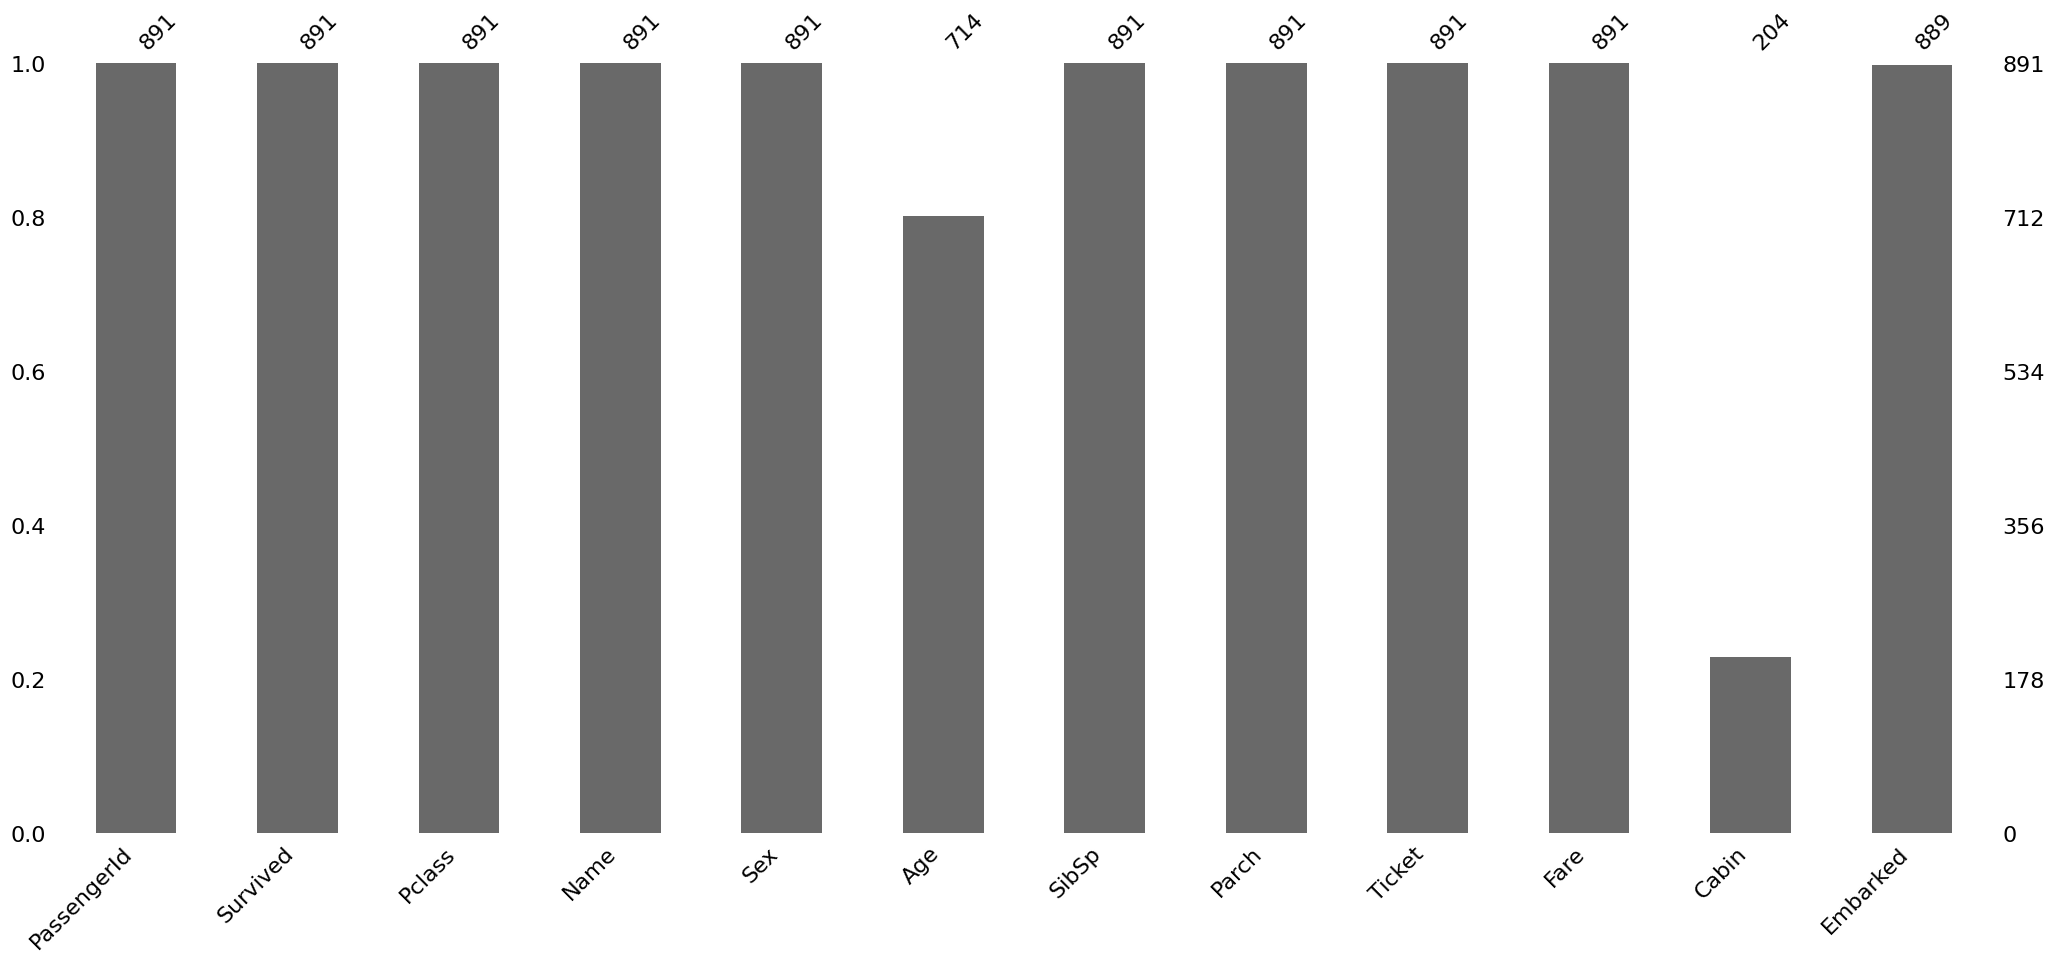

In [47]:
#############################################
# Gelişmiş Analizler
#############################################

###################
# Eksik Veri Yapısının İncelenmesi
###################
#tam olan gozlem sayılarını verir
msno.bar(df)
plt.show()

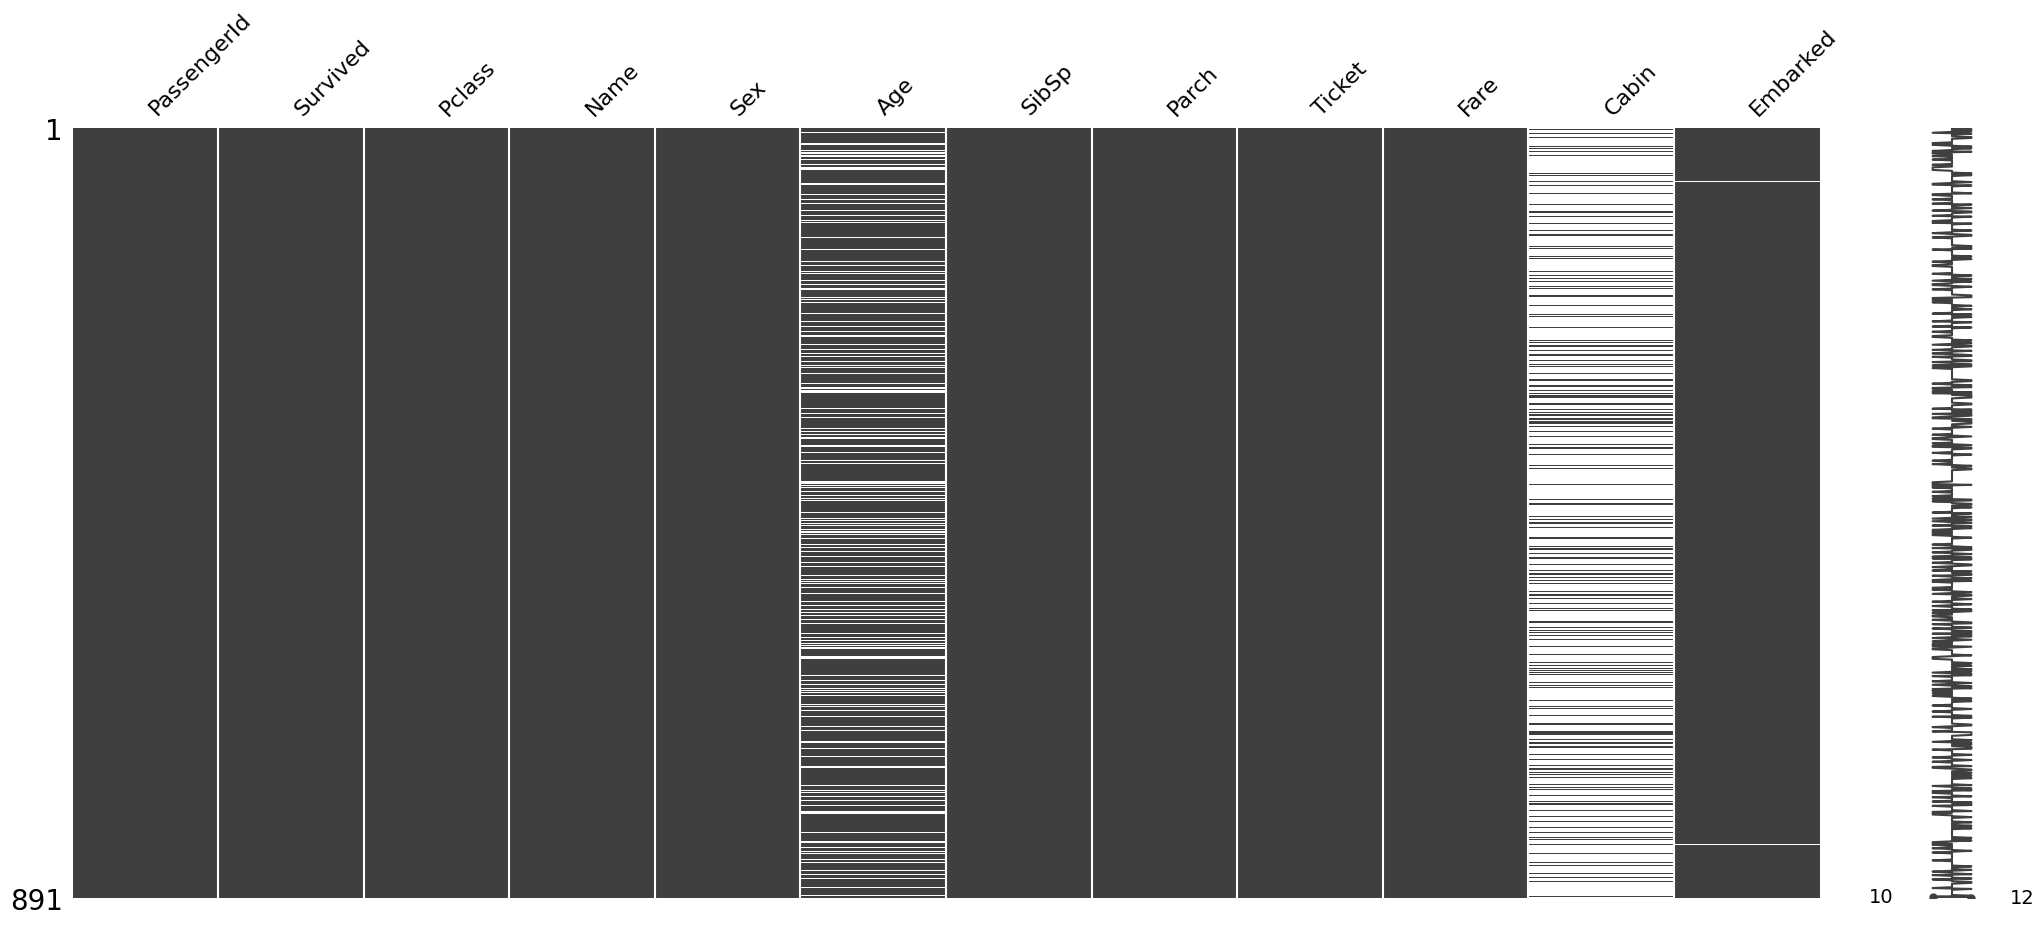

In [48]:
#değişkenlerdeki eksikliklerin birlikte çıkıp çıkmadıgını verir
msno.matrix(df)
plt.show()

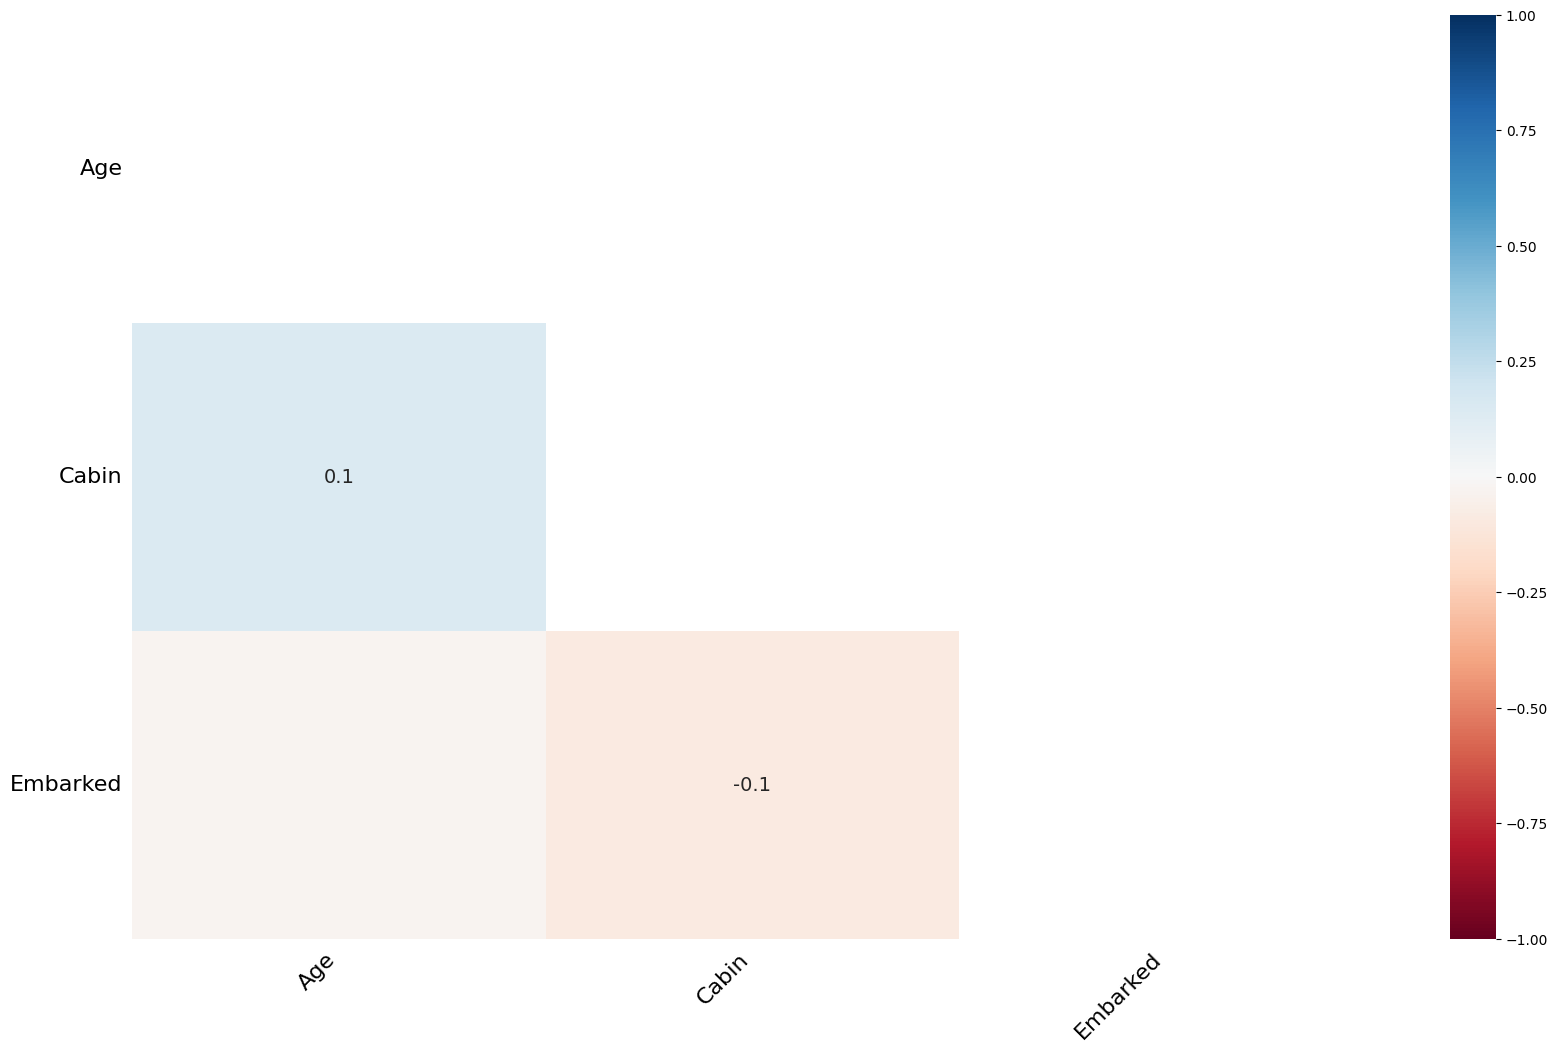

In [49]:
#eksik değerlerin belirli bir kolerasyonla birlikte ortaaya cıkıp cıkmadıgı ıle ılgıleniyorduk.
#eksikliklerin birlikte cıkması
#eksikliklerin bir değişkene bağlı çıkması
#bunların ikisi de bagımlılıktır
msno.heatmap(df)
plt.show()
#burada nullity corralationlar anlamlı gozukmuyor

In [50]:
###################
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
###################

missing_values_table(df, True)
na_cols = missing_values_table(df, True)


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)#isnul 1 diğerine 0 yaz
        
#bundan sonrasını list comprehansion yap

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Survived", na_cols)

#target bagımlı degişkenimiz

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220
          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220
             TARGET_MEAN  Count
Age_NA_FLAG                    
0                  0.406    714
1                  0.294    177


               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                    0.667    204
1                    0.300    687


                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                       0.382    889
1                       1.000      2




In [51]:
###################
# Recap
###################

df = load()
na_cols = missing_values_table(df, True)
# sayısal değişkenleri direk median ile oldurma
df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0).isnull().sum()
# kategorik değişkenleri mode ile doldurma
df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()
# kategorik değişken kırılımında sayısal değişkenleri doldurmak
df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean")).isnull().sum()
# Tahmine Dayalı Atama ile Doldurma
missing_vs_target(df, "Survived", na_cols)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220
             TARGET_MEAN  Count
Age_NA_FLAG                    
0                  0.406    714
1                  0.294    177


               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                    0.667    204
1                    0.300    687


                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                       0.382    889
1                       1.000      2




In [52]:
#############################################
# 3. Encoding (Label Encoding, One-Hot Encoding, Rare Encoding)
#############################################
#mezuniyet ordinal binarye gecerse 012345 şeklinde sıralı ve buyukluk belirtir. nominal olanlarda 
#bu tercih edilmez. one hot encodıng uyg. iki sınıflıysa zaten yine binary
#############################################
# Label Encoding & Binary Encoding
#############################################

df = load()
df.head()
df["Sex"].head()

le = LabelEncoder()#iki sınıflıysa binary, birden fazla ise label veya one hot
le.fit_transform(df["Sex"])[0:5]#alfabetik sıraya gore ilk gelene 0 verir
le.inverse_transform([0, 1])

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

df = load()

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

df.head()

df = load_application_train()
df.shape

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

df[binary_cols].head()


for col in binary_cols:
    label_encoder(df, col)


df = load()
df["Embarked"].value_counts()
df["Embarked"].nunique()
len(df["Embarked"].unique())


4

In [53]:
#############################################
# One-Hot Encoding
#############################################

df = load()
df.head()
df["Embarked"].value_counts()

pd.get_dummies(df, columns=["Embarked"]).head()

pd.get_dummies(df, columns=["Embarked"], drop_first=True).head()#ilk sıra alfabetik olarak uctu

pd.get_dummies(df, columns=["Embarked"], dummy_na=True).head()#na de bir num verir

pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True).head()#drop firstten dolayı sex male ise 1 değilse 0 doner, get dummies binary encoding için ve one hot e için kull.

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = load()

# cat_cols, num_cols, cat_but_car = grab_col_names(df)

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]


one_hot_encoder(df, ohe_cols).head()

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [54]:

#############################################
# Rare Encoding
#############################################

# 1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
# 2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.
# 3. Rare encoder yazacağız.

###################
# 1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
###################

df = load_application_train()
df["NAME_EDUCATION_TYPE"].value_counts()

cat_cols, num_cols, cat_but_car = grab_col_names(df)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39
                    NAME_CONTRACT_TYPE  Ratio
NAME_CONTRACT_TYPE                           
Cash loans                      278232 90.479
Revolving loans                  29279  9.521
##########################################
             CODE_GENDER  Ratio
CODE_GENDER                    
F                 202448 65.834
M                 105059 34.164
XNA                    4  0.001
##########################################
              FLAG_OWN_CAR  Ratio
FLAG_OWN_CAR                     
N                   202924 65.989
Y                   104587 34.011
##########################################
                 FLAG_OWN_REALTY  Ratio
FLAG_OWN_REALTY                        
Y                         213312 69.367
N                          94199 30.633
##########################################
                 NAME_TYPE_SUITE  Ratio
NAME_TYPE_SUITE                        
Unaccompanied  

In [55]:
###################
# 2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.
###################

df["NAME_INCOME_TYPE"].value_counts()

df.groupby("NAME_INCOME_TYPE")["TARGET"].mean()


def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "TARGET", cat_cols)

NAME_CONTRACT_TYPE : 2
                     COUNT  RATIO  TARGET_MEAN
NAME_CONTRACT_TYPE                            
Cash loans          278232  0.905        0.083
Revolving loans      29279  0.095        0.055


CODE_GENDER : 3
              COUNT  RATIO  TARGET_MEAN
CODE_GENDER                            
F            202448  0.658        0.070
M            105059  0.342        0.101
XNA               4  0.000        0.000


FLAG_OWN_CAR : 2
               COUNT  RATIO  TARGET_MEAN
FLAG_OWN_CAR                            
N             202924  0.660        0.085
Y             104587  0.340        0.072


FLAG_OWN_REALTY : 2
                  COUNT  RATIO  TARGET_MEAN
FLAG_OWN_REALTY                            
N                 94199  0.306        0.083
Y                213312  0.694        0.080


NAME_TYPE_SUITE : 7
                  COUNT  RATIO  TARGET_MEAN
NAME_TYPE_SUITE                            
Children           3267  0.011        0.074
Family            40149  0.131      

In [56]:
#############################################
# 3. Rare encoder'ın yazılması.
#############################################

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

new_df = rare_encoder(df, 0.01)

rare_analyser(new_df, "TARGET", cat_cols)

df["OCCUPATION_TYPE"].value_counts()


NAME_CONTRACT_TYPE : 2
                     COUNT  RATIO  TARGET_MEAN
NAME_CONTRACT_TYPE                            
Cash loans          278232  0.905        0.083
Revolving loans      29279  0.095        0.055


CODE_GENDER : 3
              COUNT  RATIO  TARGET_MEAN
CODE_GENDER                            
F            202448  0.658        0.070
M            105059  0.342        0.101
Rare              4  0.000        0.000


FLAG_OWN_CAR : 2
               COUNT  RATIO  TARGET_MEAN
FLAG_OWN_CAR                            
N             202924  0.660        0.085
Y             104587  0.340        0.072


FLAG_OWN_REALTY : 2
                  COUNT  RATIO  TARGET_MEAN
FLAG_OWN_REALTY                            
N                 94199  0.306        0.083
Y                213312  0.694        0.080


NAME_TYPE_SUITE : 5
                  COUNT  RATIO  TARGET_MEAN
NAME_TYPE_SUITE                            
Children           3267  0.011        0.074
Family            40149  0.131      

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

In [57]:
#############################################
# Feature Scaling (Özellik Ölçeklendirme)
#############################################

###################
# StandardScaler: Klasik standartlaştırma. Ortalamayı çıkar, standart sapmaya böl. z = (x - u) / s
###################

df = load()
ss = StandardScaler()
df["Age_standard_scaler"] = ss.fit_transform(df[["Age"]])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_standard_scaler
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,-0.530
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,0.572
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,-0.255
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,0.365
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0.365


In [58]:
###################
# RobustScaler: Medyanı çıkar iqr'a böl.#aykırı değerlere daha dayanıklı
###################

rs = RobustScaler()
df["Age_robuts_scaler"] = rs.fit_transform(df[["Age"]])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000,446.000,257.354,1.000,223.500,446.000,668.500,891.000
Survived,891.000,0.384,0.487,0.000,0.000,0.000,1.000,1.000
Pclass,891.000,2.309,0.836,1.000,2.000,3.000,3.000,3.000
Age,714.000,29.699,14.526,0.420,20.125,28.000,38.000,80.000
SibSp,891.000,0.523,1.103,0.000,0.000,0.000,1.000,8.000
Parch,891.000,0.382,0.806,0.000,0.000,0.000,0.000,6.000
Fare,891.000,32.204,49.693,0.000,7.910,14.454,31.000,512.329
Age_standard_scaler,714.000,0.000,1.001,-2.017,-0.660,-0.117,0.572,3.465
Age_robuts_scaler,714.000,0.095,0.813,-1.543,-0.441,0.000,0.559,2.909


count   714.000
mean     29.699
std      14.526
min       0.420
5%        4.000
10%      14.000
20%      19.000
30%      22.000
40%      25.000
50%      28.000
60%      31.800
70%      36.000
80%      41.000
90%      50.000
95%      56.000
99%      65.870
max      80.000
Name: Age, dtype: float64


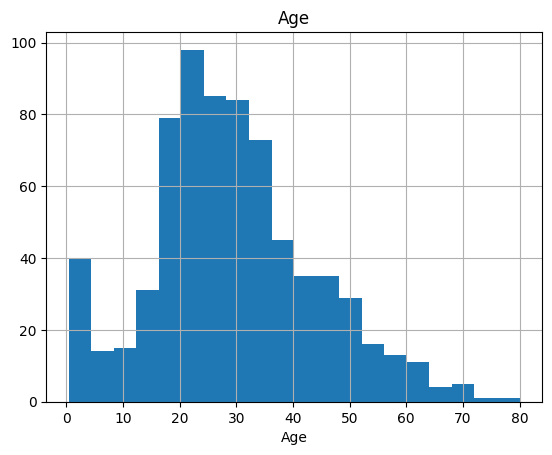

count   714.000
mean      0.000
std       1.001
min      -2.017
5%       -1.770
10%      -1.081
20%      -0.737
30%      -0.530
40%      -0.324
50%      -0.117
60%       0.145
70%       0.434
80%       0.778
90%       1.398
95%       1.812
99%       2.492
max       3.465
Name: Age_standard_scaler, dtype: float64


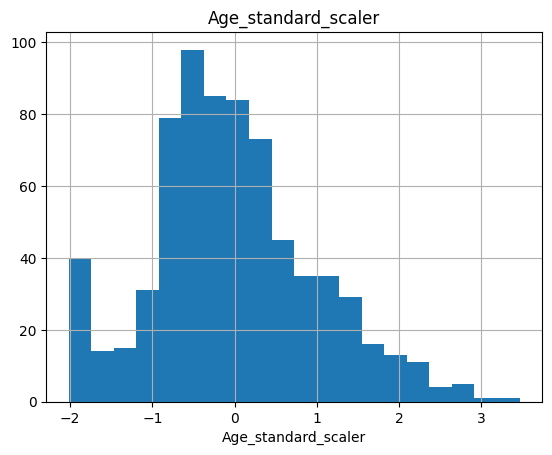

count   714.000
mean      0.095
std       0.813
min      -1.543
5%       -1.343
10%      -0.783
20%      -0.503
30%      -0.336
40%      -0.168
50%       0.000
60%       0.213
70%       0.448
80%       0.727
90%       1.231
95%       1.566
99%       2.119
max       2.909
Name: Age_robuts_scaler, dtype: float64


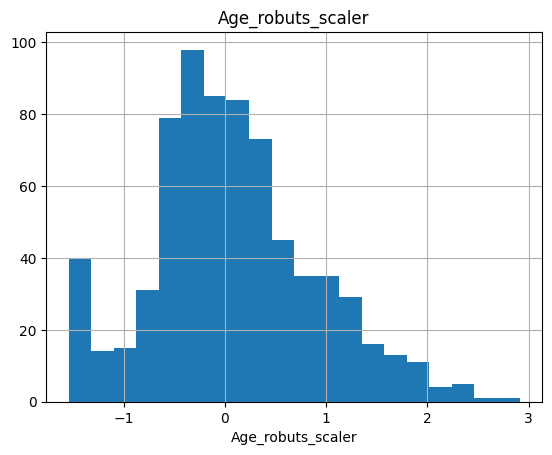

count   714.000
mean      0.368
std       0.183
min       0.000
5%        0.045
10%       0.171
20%       0.233
30%       0.271
40%       0.309
50%       0.347
60%       0.394
70%       0.447
80%       0.510
90%       0.623
95%       0.698
99%       0.822
max       1.000
Name: Age_min_max_scaler, dtype: float64


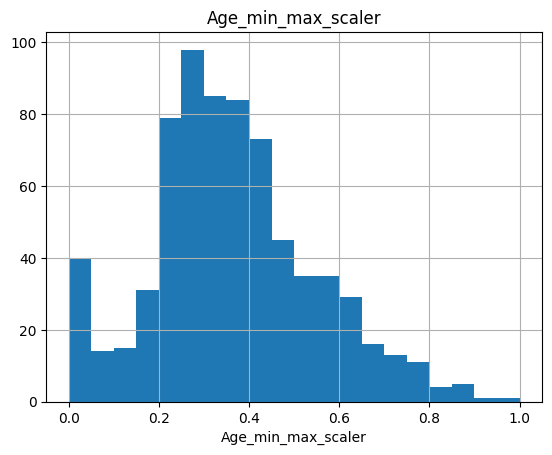

In [59]:
###################
# MinMaxScaler: Verilen 2 değer arasında değişken dönüşümü
###################

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

mms = MinMaxScaler()
df["Age_min_max_scaler"] = mms.fit_transform(df[["Age"]])
df.describe().T

df.head()

age_cols = [col for col in df.columns if "Age" in col]

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in age_cols:
    num_summary(df, col, plot=True)

In [60]:
###################
# Numeric to Categorical: Sayısal Değişkenleri Kateorik Değişkenlere Çevirme
# Binning
###################

df["Age_qcut"] = pd.qcut(df['Age'], 5)

In [61]:
#############################################
# Feature Extraction (Özellik Çıkarımı)
#############################################

#############################################
# Binary Features: Flag, Bool, True-False
#############################################

df = load()
df.head()

df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')

df.groupby("NEW_CABIN_BOOL").agg({"Survived": "mean"})


from statsmodels.stats.proportion import proportions_ztest

test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].sum(),
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].shape[0],
                                            df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"

df.groupby("NEW_IS_ALONE").agg({"Survived": "mean"})


test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].sum(),
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].shape[0],
                                            df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 9.4597, p-value = 0.0000
Test Stat = -6.0704, p-value = 0.0000


In [62]:
#############################################
# Text'ler Üzerinden Özellik Türetmek
#############################################

df.head()

###################
# Letter Count
###################

df["NEW_NAME_COUNT"] = df["Name"].str.len()

###################
# Word Count
###################

df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))

###################
# Özel Yapıları Yakalamak
###################

df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

df.groupby("NEW_NAME_DR").agg({"Survived": ["mean","count"]})

Survived      
                mean count
NEW_NAME_DR               
0              0.383   881
1              0.500    10

In [63]:
###################
# Regex ile Değişken Türetmek
###################

df.head()

df['NEW_TITLE'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


df[["NEW_TITLE", "Survived", "Age"]].groupby(["NEW_TITLE"]).agg({"Survived": "mean", "Age": ["count", "mean"]})


Survived   Age       
              mean count   mean
NEW_TITLE                      
Capt         0.000     1 70.000
Col          0.500     2 58.000
Countess     1.000     1 33.000
Don          0.000     1 40.000
Dr           0.429     6 42.000
Jonkheer     0.000     1 38.000
Lady         1.000     1 48.000
Major        0.500     2 48.500
Master       0.575    36  4.574
Miss         0.698   146 21.774
Mlle         1.000     2 24.000
Mme          1.000     1 24.000
Mr           0.157   398 32.368
Mrs          0.792   108 35.898
Ms           1.000     1 28.000
Rev          0.000     6 43.167
Sir          1.000     1 49.000

In [64]:
#############################################
# Date Değişkenleri Üretmek
#############################################

dff = pd.read_csv("/kaggle/input/dataset-for-date-fe/course_reviews.csv")
dff.head()
dff.info()

dff['Timestamp'] = pd.to_datetime(dff["Timestamp"])

# year
dff['year'] = dff['Timestamp'].dt.year

# month
dff['month'] = dff['Timestamp'].dt.month

# year diff
dff['year_diff'] = date.today().year - dff['Timestamp'].dt.year

# month diff (iki tarih arasındaki ay farkı): yıl farkı + ay farkı
dff['month_diff'] = (date.today().year - dff['Timestamp'].dt.year) * 12 + date.today().month - dff['Timestamp'].dt.month


# day name
dff['day_name'] = dff['Timestamp'].dt.day_name()

dff.head()

# date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rating              4323 non-null   float64
 1   Timestamp           4323 non-null   object 
 2   Enrolled            4323 non-null   object 
 3   Progress            4323 non-null   float64
 4   Questions Asked     4323 non-null   float64
 5   Questions Answered  4323 non-null   float64
dtypes: float64(4), object(2)
memory usage: 202.8+ KB


,Rating,Timestamp,Enrolled,Progress,Questions Asked,Questions Answered,year,month,year_diff,month_diff,day_name
0,5.000,2021-02-05 07:45:55,2021-01-25 15:12:08,5.000,0.000,0.000,2021,2,3,40,Friday
1,5.000,2021-02-04 21:05:32,2021-02-04 20:43:40,1.000,0.000,0.000,2021,2,3,40,Thursday
2,4.500,2021-02-04 20:34:03,2019-07-04 23:23:27,1.000,0.000,0.000,2021,2,3,40,Thursday
3,5.000,2021-02-04 16:56:28,2021-02-04 14:41:29,10.000,0.000,0.000,2021,2,3,40,Thursday
4,4.000,2021-02-04 15:00:24,2020-10-13 03:10:07,10.000,0.000,0.000,2021,2,3,40,Thursday


In [65]:
#############################################
# Feature Interactions (Özellik Etkileşimleri)
#############################################
df = load()
df.head()

df["NEW_AGE_PCLASS"] = df["Age"] * df["Pclass"]

df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1

df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'

df.loc[(df['Sex'] == 'male') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturemale'

df.loc[(df['Sex'] == 'male') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'

df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'


df.head()

df.groupby("NEW_SEX_CAT")["Survived"].mean()

NEW_SEX_CAT
maturefemale   0.774
maturemale     0.199
seniorfemale   0.909
seniormale     0.135
youngfemale    0.679
youngmale      0.250
Name: Survived, dtype: float64

In [66]:
#############################################
# Titanic Uçtan Uca Feature Engineering & Data Preprocessing
#############################################

df = load()
df.shape
df.head()

df.columns = [col.upper() for col in df.columns]

#############################################
# 1. Feature Engineering (Değişken Mühendisliği)
#############################################

# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df.head()
df.shape

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

#############################################
# 2. Outliers (Aykırı Değerler)
#############################################

for col in num_cols:
    print(col, check_outlier(df, col))

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

#############################################
# 3. Missing Values (Eksik Değerler)
#############################################

missing_values_table(df)

df.drop("CABIN", inplace=True, axis=1)

remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)


df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))


df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'


df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

#############################################
# 4. Label Encoding
#############################################

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    df = label_encoder(df, col)


#############################################
# 5. Rare Encoding
#############################################

rare_analyser(df, "SURVIVED", cat_cols)


df = rare_encoder(df, 0.01)

df["NEW_TITLE"].value_counts()

#############################################
# 6. One-Hot Encoding
#############################################

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

df.head()
df.shape


cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

rare_analyser(df, "SURVIVED", cat_cols)

useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

# df.drop(useless_cols, axis=1, inplace=True)

#############################################
# 7. Standart Scaler
#############################################

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

df.head()
df.shape


#############################################
# 8. Model
#############################################

y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)


Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8
AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True
AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False
                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
NEW_SEX_CAT        177 19.870
EMBARKED             2  0.220
SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339


NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             

0.8059701492537313

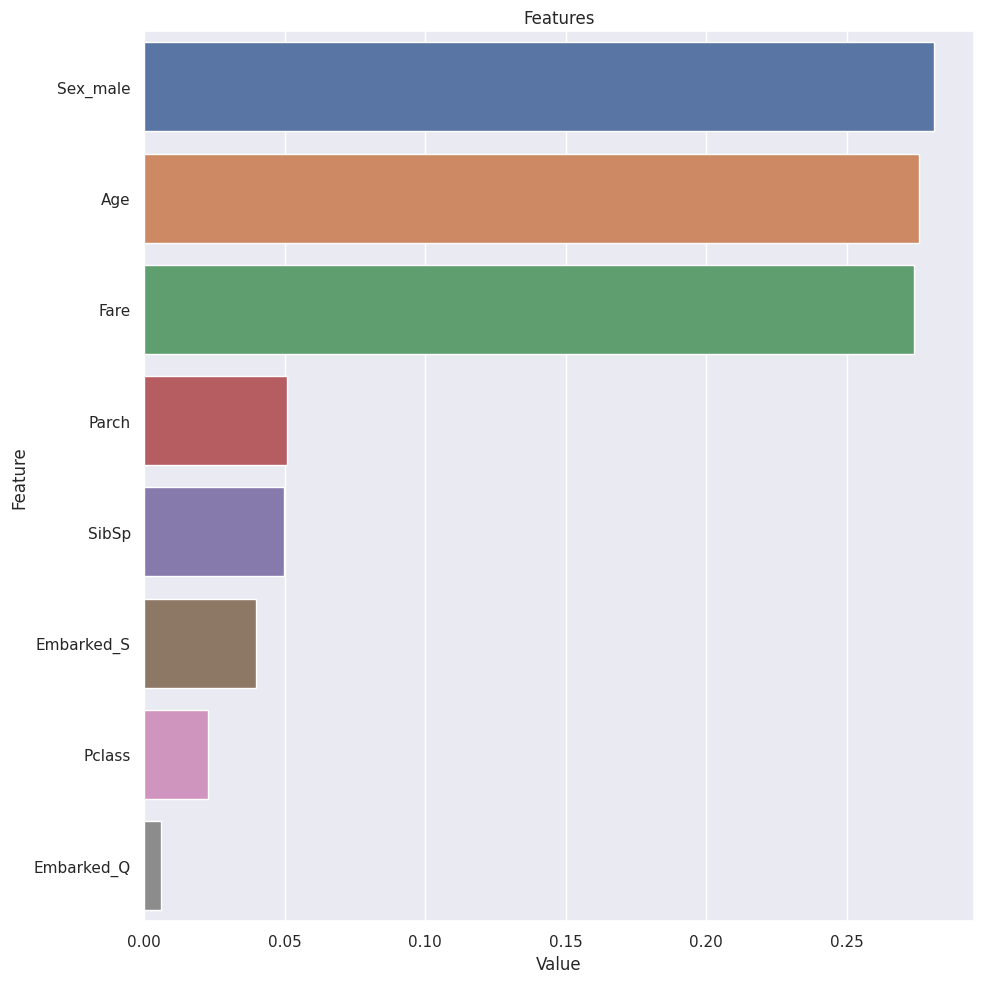

In [67]:
#############################################
# Hiç bir işlem yapılmadan elde edilecek skor?
#############################################
from sklearn.ensemble import RandomForestClassifier

dff = load()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

# Yeni ürettiğimiz değişkenler ne alemde?

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X_train)